In [ ]:
%cd /content/drive/MyDrive/Train
%ls

/content/drive/MyDrive/Train
data/               pix1.data  Test.zip         Train.zip
data_for_colab.zip  pix2.data  Train/           val/
data.zip            pix3.data  trainvgg.zip     vggmodel.h5
mydataset.yaml      Test/      trainyolov8.zip  weights-01-0.99.hdf5


In [ ]:
!unzip "/content/drive/MyDrive/Train/trainvgg.zip" -d "/content/data/"

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: /content/data/train/Banh_Hoa_Hong/847.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/848.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/849.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/85.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/851.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/852.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/853.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/854.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/856.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/857.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/858.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/859.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/86.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/861.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/862.jpg  
  inflating: /content/data/train/Banh_Hoa_Hong/863.jpg  
  inflating: /content/data/train/

In [ ]:
%ls


data/               pix1.data  Test.zip         Train.zip
data_for_colab.zip  pix2.data  Train/           val/
data.zip            pix3.data  trainvgg.zip     vggmodel.h5
mydataset.yaml      Test/      trainyolov8.zip  weights-01-0.99.hdf5


In [ ]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90,
                                     brightness_range=[0.7, 1.2],
                                     horizontal_flip=True,
                                     vertical_flip=True,
                                     preprocessing_function=preprocess_input)
val_generator = ImageDataGenerator()

In [ ]:
class_subset = 6
train_data_dir ="/content/data/train/"
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)
val_data_dir = "/content/data/val/"

validgen = val_generator.flow_from_directory(val_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

TypeError: ignored

In [ ]:
TRAINING_DIR = "/content/data/train/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=90,
      brightness_range=[0.7, 1.2],
      horizontal_flip=True,
      vertical_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "/content/data/val/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=64
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(224,224),
	class_mode='categorical',
  batch_size=64
)

Found 5301 images belonging to 6 classes.
Found 1333 images belonging to 6 classes.


In [ ]:
from keras.callbacks import ReduceLROnPlateau
lr_reduce = ReduceLROnPlateau(monitor='val_accuracy',
                              factor=0.6, patience=8,
                              verbose=1, mode='max',
                              min_lr=5e-5)
checkpoint = ModelCheckpoint('vgg16_finetune.h15',
                             monitor= 'val_accuracy',
                             mode= 'max',
                             save_best_only = True,
                             verbose= 1)

In [ ]:
vgg_model = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(224, 224, 3))

for layer in vgg_model.layers[:15]:
    layer.trainable = False

x = vgg_model.output
x = Flatten()(x) # Flatten dimensions to for use in FC layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x) # Dropout layer to reduce overfitting
x = Dense(256, activation='relu')(x)
x= Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x) # Softmax for multiclass
transfer_model = Model(inputs=vgg_model.input, outputs=x)

58889256/58889256 [==============================] - 4s 0us/step


In [ ]:
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:

learning_rate= 0.0001
transfer_model.compile(loss="categorical_crossentropy",
                       optimizer= Adam(lr=learning_rate),
                       metrics=["accuracy"])
history = transfer_model.fit(train_generator,
                             epochs=50,
                             steps_per_epoch=22,
                             validation_data = validation_generator,

                             validation_steps=5,
                             callbacks=[lr_reduce],
                             verbose = 1)

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
22/22 [==============================] - 45s 1s/step - loss: 1.0421 - accuracy: 0.5952 - val_loss: 0.1618 - val_accuracy: 0.9469 - lr: 1.0000e-04
Epoch 2/50
22/22 [==============================] - 28s 1s/step - loss: 0.2520 - accuracy: 0.9084 - val_loss: 0.0509 - val_accuracy: 0.9875 - lr: 1.0000e-04
Epoch 3/50
22/22 [==============================] - 27s 1s/step - loss: 0.1107 - accuracy: 0.9652 - val_loss: 0.0334 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 4/50
22/22 [==============================] - 34s 2s/step - loss: 0.0653 - accuracy: 0.9749 - val_loss: 0.0111 - val_accuracy: 0.9969 - lr: 1.0000e-04
Epoch 5/50
22/22 [==============================] - 28s 1s/step - loss: 0.0357 - accuracy: 0.9872 - val_loss: 0.0319 - val_accuracy: 0.9937 - lr: 1.0000e-04
Epoch 6/50
22/22 [==============================] - 28s 1s/step - loss: 0.0425 - accuracy: 0.9851 - val_loss: 0.0029 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/50
22/22 [==============================] - 28s 1s

In [ ]:
transfer_model.save("vgg16FineTuning2.h5")

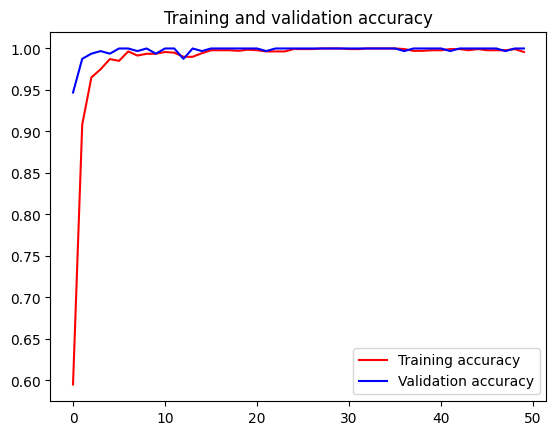

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

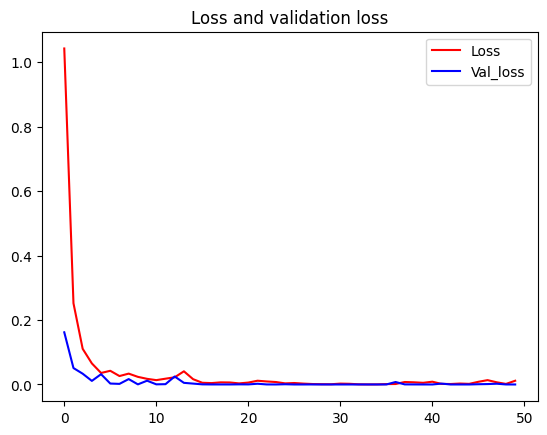

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, loss, 'r', label='Loss')
plt.plot(epochs, val_loss, 'b', label='Val_loss')
plt.title('Loss and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
import tensorflow as tf
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

history = model.fit(train_generator,
                    epochs=50,
                    steps_per_epoch=22,
                    validation_data = validation_generator,
                    verbose = 1,
                    validation_steps=5)

model.save("rps.h5")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

InvalidArgumentError: ignored